In [251]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import re
import optuna

In [219]:
train_df = pd.read_csv('data/train.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [220]:
test_df = pd.read_csv('data/test.csv')
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# EDA

In [221]:
train_df[['Survived', 'Embarked']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


# Feature Engineering

In [222]:
train_df['Sex'] = train_df['Sex'].map({'male' : 0, 'female' : 1})
test_df['Sex'] = test_df['Sex'].map({'male' : 0, 'female' : 1})

In [223]:

train_df['Title'] = train_df['Name'].str.extract(r'(Mr\.|Mrs\.|Ms\.|Miss|Dr\.|Rev\.)')
test_df['Title'] = test_df['Name'].str.extract(r'(Mr\.|Mrs\.|Ms\.|Miss|Dr\.|Rev\.)')

train_df = pd.get_dummies(train_df, columns = ['Title'])
test_df = pd.get_dummies(test_df, columns = ['Title'])


In [224]:
train_df['Age'] = train_df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x : x.fillna(x.median()))
test_df['Age'] = train_df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x : x.fillna(x.median()))

In [225]:
train_df['Fare'] = train_df.groupby(['Sex', 'Pclass'])['Fare'].transform(lambda x : x.fillna(x.median()))
test_df['Fare'] = train_df.groupby(['Sex', 'Pclass'])['Fare'].transform(lambda x : x.fillna(x.median()))

In [226]:
train_df['Fare_Per_Person'] = train_df['Fare'] / (1 + train_df['SibSp'] + train_df['Parch'])
test_df['Fare_Per_Person'] = test_df['Fare'] / (1 + test_df['SibSp'] + test_df['Parch'])

In [227]:
train_df = pd.get_dummies(train_df, columns = ['Embarked'])
test_df = pd.get_dummies(test_df, columns = ['Embarked'])

In [228]:
title_one_hot = [col for col in train_df.columns if col.startswith('Title_')]
title_one_hot

['Title_Dr.',
 'Title_Miss',
 'Title_Mr.',
 'Title_Mrs.',
 'Title_Ms.',
 'Title_Rev.']

In [229]:
embarked_one_hot = [col for col in train_df.columns if col.startswith('Embarked_')]
embarked_one_hot

['Embarked_C', 'Embarked_Q', 'Embarked_S']

In [230]:
train_df['Is_Baby'] = train_df['Age'] <= 3
test_df['Is_Baby'] = test_df['Age'] <= 3

# Training

In [231]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_Per_Person', 'Is_Baby'] + title_one_hot + embarked_one_hot

In [232]:
df = train_df[['Survived'] + features]
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_Per_Person,Is_Baby,Title_Dr.,Title_Miss,Title_Mr.,Title_Mrs.,Title_Ms.,Title_Rev.,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,3.62500,False,False,False,True,False,False,False,False,False,True
1,1,1,1,38.0,1,0,71.2833,35.64165,False,False,False,False,True,False,False,True,False,False
2,1,3,1,26.0,0,0,7.9250,7.92500,False,False,True,False,False,False,False,False,False,True
3,1,1,1,35.0,1,0,53.1000,26.55000,False,False,False,False,True,False,False,False,False,True
4,0,3,0,35.0,0,0,8.0500,8.05000,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,13.00000,False,False,False,False,False,False,True,False,False,True
887,1,1,1,19.0,0,0,30.0000,30.00000,False,False,True,False,False,False,False,False,False,True
888,0,3,1,21.5,1,2,23.4500,5.86250,False,False,True,False,False,False,False,False,False,True
889,1,1,0,26.0,0,0,30.0000,30.00000,False,False,False,True,False,False,False,True,False,False


In [233]:
X = df[features]
y = df['Survived']

In [234]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Random Forest

In [235]:
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [241]:
y_pred = model.predict(X_val)

In [242]:
print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.8491620111731844


## XGBoost

In [258]:
folder = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

In [259]:
xgb_model = xgb.XGBClassifier(
    use_label_encoder = False,
    eval_metric='logloss', 
    random_state=42  
)

In [260]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}


In [261]:
grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    cv = folder,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = 1

)

In [279]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/train

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [280]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}

In [281]:
grid_search.best_score_

np.float64(0.8398699891657639)

In [283]:
best_xgb_model = grid_search.best_estimator_

In [284]:
val_preds = best_xgb_model.predict(X_val)
print(accuracy_score(y_val, val_preds))

0.8044692737430168


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

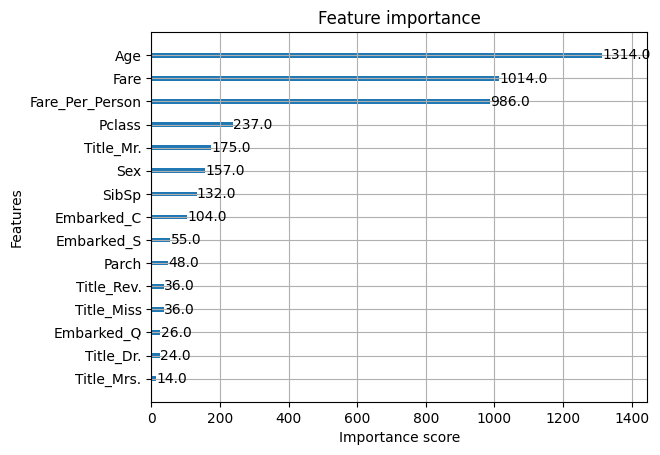

In [273]:
xgb.plot_importance(best_xgb_model, max_num_features = len(train_df.columns))

# Submission

In [275]:
MODEL_CHOICE = best_xgb_model

In [276]:
test_features = test_df[features]

In [278]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': MODEL_CHOICE.predict(test_features)
})
submission.to_csv('submission_v3_xgb.csv', index=False)